In [1]:
import torch.nn as nn

In [2]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            # nz will be the input to the first convolution
            nn.ConvTranspose2d(
                nz, 512, kernel_size=4, 
                stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                512, 256, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                256, 128, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                128, 64, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                64, 3, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(
                3, 64, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                64, 128, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                128, 256, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                256, 512, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                512, 1, kernel_size=4, 
                stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [4]:
import torch
import torch.nn as nn
from torchvision.utils import save_image
# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def label_real(size):
    """
    Fucntion to create real labels (ones)
    :param size: batch size
    :return real label vector
    """
    data = torch.ones(size, 1)
    return data.to(device)
def label_fake(size):
    """
    Fucntion to create fake labels (zeros)
    :param size: batch size
    :returns fake label vector
    """
    data = torch.zeros(size, 1)
    return data.to(device)

In [6]:
def create_noise(sample_size, nz):
    """
    Fucntion to create noise
    :param sample_size: fixed sample size or batch size
    :param nz: latent vector size
    :returns random noise vector
    """
    return torch.randn(sample_size, nz, 1, 1).to(device)

In [7]:
def save_generator_image(image, path):
    """
    Function to save torch image batches
    :param image: image tensor batch
    :param path: path name to save image
    """
    save_image(image, path, normalize=True)

In [8]:
def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import numpy as np
import matplotlib

from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [10]:
image_size = 64 # we need to resize image to 64x64
batch_size = 128
nz = 100 # latent vector size
beta1 = 0.5 # beta1 value for Adam optimizer
lr = 0.0002 # learning rate according to paper
sample_size = 64 # fixed sample size
epochs = 25 # number of epoch to train
# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), 
    (0.5, 0.5, 0.5)),
])

In [12]:
train_data = datasets.CIFAR10(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

Extracting ../input/data/cifar-10-python.tar.gz to ../input/data


In [13]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device) 

In [14]:
# initialize generator weights
generator.apply(weights_init)
# initialize discriminator weights
discriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [15]:
optim_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
# loss function
criterion = nn.BCELoss()

In [16]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch

In [17]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    # get the real label vector
    real_label = label_real(b_size)
    # get the fake label vector
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    # get the outputs by doing real data forward pass
    output_real = discriminator(data_real).view(-1, 1)

    loss_real = criterion(output_real, real_label.view(-1,1))
    # get the outputs by doing fake data forward pass
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake.view(-1,1,1,1), fake_label.view(-1,1,1,1))
    # compute gradients of real loss 
    loss_real.backward()
    # compute gradients of fake loss
    loss_fake.backward()
    # update discriminator parameters
    optimizer.step()
    return loss_real + loss_fake

In [18]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    # get the real label vector
    real_label = label_real(b_size)
    optimizer.zero_grad()
    # output by doing a forward pass of the fake data through discriminator
    output = discriminator(data_fake)
    loss = criterion(output.view(-1,1), real_label.view(-1,1))
    # compute gradients of loss
    loss.backward()
    # update generator parameters
    optimizer.step()
    return loss 

In [19]:
noise = create_noise(sample_size, nz)

In [20]:
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [21]:
for epoch in range(20):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # forward pass through generator to create fake data
        data_fake = generator(create_noise(b_size, nz)).detach()
        data_real = image
        loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        loss_g += train_generator(optim_g, data_fake)
    # final forward pass through generator to create fake data...
    # ...after training for current epoch
    generated_img = generator(noise).cpu().detach()
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"gen_img{epoch}.png")
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

391it [01:21,  4.83it/s]
  0%|          | 1/390 [00:00<01:12,  5.39it/s]

Epoch 1 of 25
Generator loss: 8.19159412, Discriminator loss: 0.42713144


391it [01:25,  4.58it/s]
  0%|          | 1/390 [00:00<01:12,  5.35it/s]

Epoch 2 of 25
Generator loss: 5.54022598, Discriminator loss: 0.53091568


391it [01:27,  4.48it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 3 of 25
Generator loss: 3.63583493, Discriminator loss: 0.65280151


391it [01:28,  4.41it/s]
  0%|          | 1/390 [00:00<01:14,  5.24it/s]

Epoch 4 of 25
Generator loss: 3.51597953, Discriminator loss: 0.66251576


391it [01:27,  4.45it/s]
  0%|          | 1/390 [00:00<01:16,  5.09it/s]

Epoch 5 of 25
Generator loss: 3.20359325, Discriminator loss: 0.68667841


391it [01:27,  4.47it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 6 of 25
Generator loss: 2.87921047, Discriminator loss: 0.73589349


391it [01:27,  4.47it/s]
  0%|          | 1/390 [00:00<01:15,  5.16it/s]

Epoch 7 of 25
Generator loss: 2.68480110, Discriminator loss: 0.81472021


391it [01:28,  4.44it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 8 of 25
Generator loss: 2.87128949, Discriminator loss: 0.72224522


391it [01:28,  4.41it/s]
  0%|          | 1/390 [00:00<01:14,  5.23it/s]

Epoch 9 of 25
Generator loss: 3.09438491, Discriminator loss: 0.78668201


391it [01:28,  4.43it/s]
  0%|          | 1/390 [00:00<01:14,  5.23it/s]

Epoch 10 of 25
Generator loss: 3.17283225, Discriminator loss: 0.68306488


391it [01:27,  4.46it/s]
  0%|          | 1/390 [00:00<01:13,  5.30it/s]

Epoch 11 of 25
Generator loss: 3.59215283, Discriminator loss: 0.56481379


391it [01:27,  4.48it/s]
  0%|          | 1/390 [00:00<01:15,  5.18it/s]

Epoch 12 of 25
Generator loss: 3.23040128, Discriminator loss: 0.64391226


391it [01:27,  4.47it/s]
  0%|          | 1/390 [00:00<01:13,  5.28it/s]

Epoch 13 of 25
Generator loss: 4.05233717, Discriminator loss: 0.51971674


391it [01:27,  4.45it/s]
  0%|          | 1/390 [00:00<01:13,  5.26it/s]

Epoch 14 of 25
Generator loss: 3.12379599, Discriminator loss: 0.68039602


391it [01:27,  4.45it/s]
  0%|          | 1/390 [00:00<01:13,  5.32it/s]

Epoch 15 of 25
Generator loss: 2.74659967, Discriminator loss: 0.72922051


391it [01:27,  4.45it/s]
  0%|          | 1/390 [00:00<01:16,  5.06it/s]

Epoch 16 of 25
Generator loss: 4.06292248, Discriminator loss: 0.48158076


391it [01:27,  4.45it/s]
  0%|          | 1/390 [00:00<01:14,  5.19it/s]

Epoch 17 of 25
Generator loss: 2.87803316, Discriminator loss: 0.69384462


391it [01:27,  4.45it/s]
  0%|          | 1/390 [00:00<01:15,  5.16it/s]

Epoch 18 of 25
Generator loss: 3.54879212, Discriminator loss: 0.60549945


391it [01:28,  4.43it/s]
  0%|          | 1/390 [00:00<01:14,  5.25it/s]

Epoch 19 of 25
Generator loss: 2.95217443, Discriminator loss: 0.74062699


391it [01:28,  4.43it/s]


Epoch 20 of 25
Generator loss: 2.91714096, Discriminator loss: 0.68026030


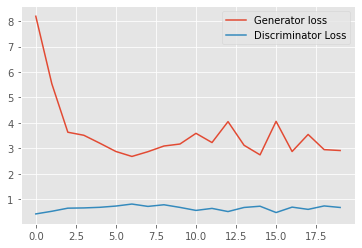

In [22]:
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()